<a href="https://colab.research.google.com/github/tnattawat/Coursera_Capstone/blob/main/IBM_Assignment_Neighborhoods_in_Toronto_3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><h1 align=center><font size =5>Segmenting and Clustering Neighborhoods in Toronto</font></h1></b>



## 1. Download and explore dataset

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# install and import geocoder
!pip install geocoder
import geocoder 

print('Libraries imported.')

Libraries imported.


In [2]:
# read table from Wikipedia into dataframe
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
df

[    Postal Code           Borough  \
 0           M1A      Not assigned   
 1           M2A      Not assigned   
 2           M3A        North York   
 3           M4A        North York   
 4           M5A  Downtown Toronto   
 5           M6A        North York   
 6           M7A  Downtown Toronto   
 7           M8A      Not assigned   
 8           M9A         Etobicoke   
 9           M1B       Scarborough   
 10          M2B      Not assigned   
 11          M3B        North York   
 12          M4B         East York   
 13          M5B  Downtown Toronto   
 14          M6B        North York   
 15          M7B      Not assigned   
 16          M8B      Not assigned   
 17          M9B         Etobicoke   
 18          M1C       Scarborough   
 19          M2C      Not assigned   
 20          M3C        North York   
 21          M4C         East York   
 22          M5C  Downtown Toronto   
 23          M6C              York   
 24          M7C      Not assigned   
 25         

In [3]:
# select relevant data
toronto_df = df[0]
toronto_df[:10]

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


In [4]:
# ignore rows with a borough that is Not assigned
toronto_df = toronto_df[toronto_df['Borough'] != 'Not assigned'].reset_index(drop=True)
toronto_df[:10]

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [5]:
# check for neighbourhoods that are Not asigned
no_neigh = toronto_df[toronto_df['Neighbourhood'] == 'Not assigned']
print("A total of {} neighbourhood(s) is Not assigned".format(len(no_neigh)))

A total of 0 neighbourhood(s) is Not assigned


It appears that there is no more 'Not asigned' in the neighbourhood column.

In [6]:
# print number of rows in the dataframe
print("Number of rows in the dataframe is: ", toronto_df.shape[0])

Number of rows in the dataframe is:  103


## 2. Obtain latitude & longtitude coordinates of each neighbourhood

In [7]:
# obtain latitude & longitude

latitude=[]
longitude=[]

for code in toronto_df['Postal Code']:
    g = geocoder.arcgis('{}, Toronto, Ontario'.format(code)) # google doesn't work, so I used arcgis
    latlng = g.latlng
    latitude.append(latlng[0])
    longitude.append(latlng[1])

In [8]:
# add latitude & longitude to the dataframe
toronto_df['Latitude'] = latitude
toronto_df['Longitude'] = longitude
toronto_df.head(12)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.66263,-79.52831
6,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
7,M3B,North York,Don Mills,43.74923,-79.36186
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.70718,-79.31192
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804


## 3. Explore and Cluster the Neighbourhoods in Toronto

In [9]:
# select only boroughs that contain the word 'Toronto'
toronto = toronto_df[toronto_df['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804
3,M5C,Downtown Toronto,St. James Town,43.65215,-79.37587
4,M4E,East Toronto,The Beaches,43.67709,-79.29547
5,M5E,Downtown Toronto,Berczy Park,43.64536,-79.37306
6,M5G,Downtown Toronto,Central Bay Street,43.65609,-79.38493
7,M6G,Downtown Toronto,Christie,43.66869,-79.42071
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.64970,-79.38258
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.66505,-79.43891


### create a map of Toronto with neighbourhoods superimposed on top

In [10]:
# define an instance of a geocoder

address = 'Toronto, Ontario'
locat = geocoder.arcgis(address)
lat = locat.lat
lng = locat.lng
print("The coordinates of Toronto are {}, {}".format(lat, lng)) 

The coordinates of Toronto are 43.648690000000045, -79.38543999999996


In [11]:
# create a map of Toronto
map_toronto = folium.Map(location=[lat, lng], zoom_start=10)

# add marker to map
for lat, lng, borough, neighbourhood in zip(toronto.Latitude, toronto.Longitude, toronto.Borough, toronto.Neighbourhood):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)

map_toronto  

## define Foursquare Credentials and Version

In [12]:
CLIENT_ID = '0M2CZMQF5ZZWZAFNTDO35XDVQXSLEKTYWYZV1VXGLEHP44Y5'
CLIENT_SECRET = 'DXDV2E2PMDV44UOZXOAV30AHQBQRZHLKAOP5ENHCVOXMQIZ3'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0M2CZMQF5ZZWZAFNTDO35XDVQXSLEKTYWYZV1VXGLEHP44Y5
CLIENT_SECRET:DXDV2E2PMDV44UOZXOAV30AHQBQRZHLKAOP5ENHCVOXMQIZ3


In [13]:
RADIUS = 500

# create url
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    lat, 
    lng, 
    VERSION,
    RADIUS, 
    LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=0M2CZMQF5ZZWZAFNTDO35XDVQXSLEKTYWYZV1VXGLEHP44Y5&client_secret=DXDV2E2PMDV44UOZXOAV30AHQBQRZHLKAOP5ENHCVOXMQIZ3&ll=43.648690000000045,-79.38543999999996&v=20180605&radius=500&limit=100'

In [14]:
# sent GET request and examine result
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fef1b1354b5505151281e10'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-50322b6ae4b09116a296568c-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/secretbar_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1d4941735',
         'name': 'Speakeasy',
         'pluralName': 'Speakeasies',
         'primary': True,
         'shortName': 'Speakeasy'}],
       'id': '50322b6ae4b09116a296568c',
       'location': {'address': '192 Adelaide St W',
        'cc': 'CA',
        'city': 'Toronto',
        'country': 'Canada',
        'crossStreet': 'at Simcoe St.',
        'distance': 88,
        'formattedAddress': ['192 Adelaide St W (at Simcoe St.)',
         'Toronto ON M5H 0A4',
         'Canada'],
        'labeledLat

## explore neighbourhoods in Toronto

Write a function to explore neighbourhoods in Toronto

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now run the above function on each neighbourhood and create a new dataframe called toronto_venues.

In [16]:
toronto_venues = getNearbyVenues(toronto.Neighbourhood, toronto.Latitude, toronto.Longitude)

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

Let's check the resulting dataframe

In [17]:
print(toronto.shape)
toronto.head()

(39, 5)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804
3,M5C,Downtown Toronto,St. James Town,43.65215,-79.37587
4,M4E,East Toronto,The Beaches,43.67709,-79.29547


Let's check how many venues were returned for each neighbourhood

In [18]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berczy Park,64,64,64,64,64,64
"Brockton, Parkdale Village, Exhibition Place",85,85,85,85,85,85
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",100,100,100,100,100,100
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",75,75,75,75,75,75
Central Bay Street,63,63,63,63,63,63
Christie,11,11,11,11,11,11
Church and Wellesley,84,84,84,84,84,84
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,30,30,30,30,30,30


Let's find out how many unique categories can be curated from all the returned venues


In [19]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 227 uniques categories.


## analyze each neighbourhood

In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

And let's examine the new dataframe size.

In [21]:
toronto_onehot.shape

(1712, 228)

Next, let's group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category


In [22]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.015625,0.000000,0.015625,0.000000,0.000000,0.000000,0.000000,0.000000,0.015625,0.031250,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000,0.00,0.015625,0.000000,0.000000,0.000000,0.00,0.015625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015625,0.015625,0.000000,0.000000,0.031250,0.000000,0.000000,0.00,0.00,0.000000,0.015625,0.046875,0.093750,0.000000,0.000000,0.00,0.00,0.015625,0.000000,0.015625,0.000000,0.000000,0.00,0.015625,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.015625,0.000000,0.000000,0.000000,0.000000,0.000000,0.015625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000,0.015625,0.000000,0.000000,0.000000,0.000000,0.00,0.015625,0.015625,0.015625,0.0000,0.000,

Let's print each neighbourhood along with the top 5 most common venues


In [23]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2  Seafood Restaurant  0.05
3         Cheese Shop  0.03
4            Beer Bar  0.03


----Brockton, Parkdale Village, Exhibition Place----
         venue  freq
0          Bar  0.07
1  Coffee Shop  0.06
2         Café  0.06
3   Restaurant  0.05
4    Gift Shop  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
              venue  freq
0       Coffee Shop  0.07
1             Hotel  0.05
2  Asian Restaurant  0.03
3              Café  0.03
4        Restaurant  0.03


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                  venue  freq
0    Italian Restaurant  0.08
1           Coffee Shop  0.07
2                  Café  0.05
3  Gym / Fitness Center  0.04
4                  Park  0.04


----Central Bay Street----
            venue  freq
0     Coffee Shop  0.11
1  Clo

Let's put that into a _pandas_ dataframe


In [24]:
#  write a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
# create new dataframe and display top 10 venues for each neighbourhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Bakery,Cheese Shop,Restaurant,Beer Bar,Farmers Market,Japanese Restaurant,Shopping Mall
1,"Brockton, Parkdale Village, Exhibition Place",Bar,Coffee Shop,Café,Restaurant,Gift Shop,Sandwich Place,Supermarket,Japanese Restaurant,Furniture / Home Store,French Restaurant
2,"Business reply mail Processing Centre, South C...",Coffee Shop,Hotel,Asian Restaurant,Café,Restaurant,Steakhouse,Japanese Restaurant,Salad Place,Salon / Barbershop,Sandwich Place
3,"CN Tower, King and Spadina, Railway Lands, Har...",Italian Restaurant,Coffee Shop,Café,Park,Gym / Fitness Center,French Restaurant,Bar,Lounge,Grocery Store,Sandwich Place
4,Central Bay Street,Coffee Shop,Clothing Store,Hotel,Plaza,Middle Eastern Restaurant,Bubble Tea Shop,Cosmetics Shop,Restaurant,Sandwich Place,Café


## 4. Cluster neighbors

Perform elbow method to find the best value of k. This method calculates the sum of squared distances from each point to its assigned center (distortions). When the distortions are plotted and the plot looks like an arm then the 'elbow' (the point of inflection on the curve) is the best value of k.

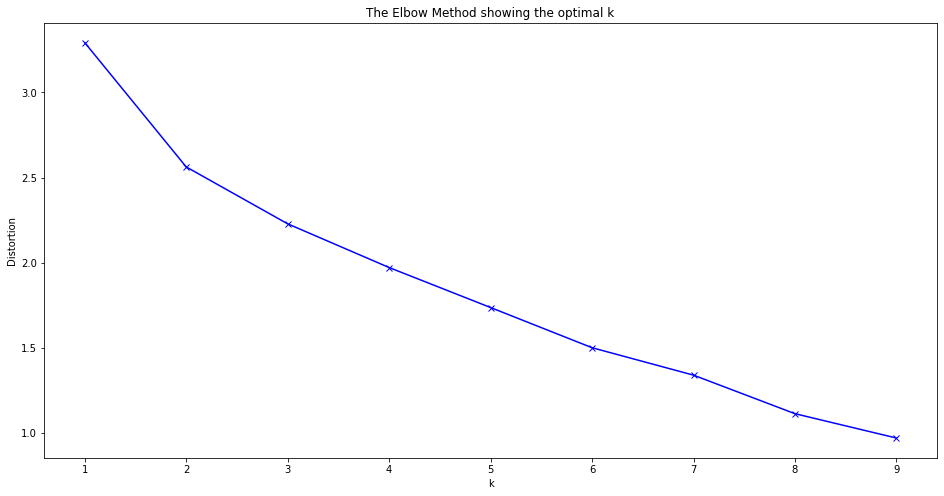

In [26]:
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run K-means with a range of k (elbow method)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

# plot the distortions of K
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can observe that the 'elbow' is the number 3 which is optimal for this case. Now we can run a K-Means using as n_clusters the number 3.

In [27]:
# define k
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighbourhood.

In [28]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighbourhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), how='right', on='Neighbourhood')


toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,M5E,Downtown Toronto,Berczy Park,43.64536,-79.37306,0,Coffee Shop,Cocktail Bar,Seafood Restaurant,Bakery,Cheese Shop,Restaurant,Beer Bar,Farmers Market,Japanese Restaurant,Shopping Mall
14,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.63941,-79.42676,0,Bar,Coffee Shop,Café,Restaurant,Gift Shop,Sandwich Place,Supermarket,Japanese Restaurant,Furniture / Home Store,French Restaurant
38,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.64869,-79.38544,0,Coffee Shop,Hotel,Asian Restaurant,Café,Restaurant,Steakhouse,Japanese Restaurant,Salad Place,Salon / Barbershop,Sandwich Place
32,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.64082,-79.39818,0,Italian Restaurant,Coffee Shop,Café,Park,Gym / Fitness Center,French Restaurant,Bar,Lounge,Grocery Store,Sandwich Place
6,M5G,Downtown Toronto,Central Bay Street,43.65609,-79.38493,0,Coffee Shop,Clothing Store,Hotel,Plaza,Middle Eastern Restaurant,Bubble Tea Shop,Cosmetics Shop,Restaurant,Sandwich Place,Café


In [29]:
toronto_merged['Cluster Labels'].value_counts()

0    31
2     6
1     1
Name: Cluster Labels, dtype: int64

Finally, let's visualize the resulting clusters.

In [30]:
# create map
map_clusters = folium.Map(location=[lat, lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

### Cluster 1

In [31]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Seafood Restaurant,Bakery,Cheese Shop,Restaurant,Beer Bar,Farmers Market,Japanese Restaurant,Shopping Mall
14,West Toronto,0,Bar,Coffee Shop,Café,Restaurant,Gift Shop,Sandwich Place,Supermarket,Japanese Restaurant,Furniture / Home Store,French Restaurant
38,East Toronto,0,Coffee Shop,Hotel,Asian Restaurant,Café,Restaurant,Steakhouse,Japanese Restaurant,Salad Place,Salon / Barbershop,Sandwich Place
32,Downtown Toronto,0,Italian Restaurant,Coffee Shop,Café,Park,Gym / Fitness Center,French Restaurant,Bar,Lounge,Grocery Store,Sandwich Place
6,Downtown Toronto,0,Coffee Shop,Clothing Store,Hotel,Plaza,Middle Eastern Restaurant,Bubble Tea Shop,Cosmetics Shop,Restaurant,Sandwich Place,Café
7,Downtown Toronto,0,Café,Grocery Store,Candy Store,Playground,Bank,Coffee Shop,Italian Restaurant,Baby Store,Yoga Studio,Farm
37,Downtown Toronto,0,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Café,Gay Bar,Dance Studio,Hotel,Fast Food Restaurant,Mediterranean Restaurant
16,Downtown Toronto,0,Coffee Shop,Restaurant,Italian Restaurant,Café,Hotel,Japanese Restaurant,American Restaurant,Gym,Beer Bar,Deli / Bodega
26,Central Toronto,0,Dessert Shop,Coffee Shop,Park,Café,Sandwich Place,Pizza Place,Italian Restaurant,Tennis Court,Fast Food Restaurant,Seafood Restaurant
9,West Toronto,0,Park,Bus Line,Pizza Place,Café,Middle Eastern Restaurant,Furniture / Home Store,Pool,Bar,Bank,Bakery


### Cluster 2

In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,1,Bus Line,Business Service,Swim School,Yoga Studio,Ethiopian Restaurant,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant


### Cluster 3

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Central Toronto,2,Park,Food & Drink Shop,Department Store,Hotel,Gym / Fitness Center,Breakfast Spot,Fast Food Restaurant,Falafel Restaurant,Farm,Farmers Market
21,Central Toronto,2,Locksmith,Park,Yoga Studio,Elementary School,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
22,West Toronto,2,Convenience Store,Park,Residential Building (Apartment / Condo),Sandwich Place,Yoga Studio,Electronics Store,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
29,Central Toronto,2,Tennis Court,Gym,Park,Trail,Electronics Store,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
23,Central Toronto,2,Playground,Gym Pool,Park,Electronics Store,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm
33,Downtown Toronto,2,Park,Playground,Bike Trail,Yoga Studio,Elementary School,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
